In [5]:
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset 
import torch  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터가 많아 plotly로 시각화시 인터렉션 활성화시 팅김 주의!!!! 특히 test데이터는 더더욱
config = {
    'staticPlot': True,  # 인터랙션 비활성화 (호버, 확대/축소 등)
}



Using device: cuda


In [2]:
DATA_PATH = Path("C:/Users/lim/Desktop/upstage AI/AD_project/data")
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")
def process_data(df) -> pd.DataFrame:
    numeric_cols = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
        'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
        'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
        'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
        'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
        'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
        'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8',
        'xmv_9', 'xmv_10', 'xmv_11','simulationRun'
    ]
    return df[numeric_cols]
train_a = process_data(train_data)
test_a = process_data(test_data)

df_cleaned = train_a.drop(columns=['simulationRun'])


In [9]:
simulation_groups_train = train_a.groupby('simulationRun')

# 최종적으로 상관관계 결과를 저장할 빈 데이터프레임
input_vector_train = pd.DataFrame()

# 시뮬레이션 별로 상관관계 계산
for sim_id, group in simulation_groups_train:
    # 시뮬레이션 번호 컬럼은 제거 (상관관계 계산에는 필요 없음)
    group_cleaned = group.drop(columns=['simulationRun'])
    
    # 상관관계 행렬 계산
    sim_corr = group_cleaned.corr()
    
    # 상삼각 행렬(upper triangle)만 추출 (대각선 위의 값들)
    upper_triangle = sim_corr.where(np.triu(np.ones(sim_corr.shape), k=1).astype(bool))
    
    # 상삼각 행렬을 1차원으로 펼쳐서 데이터프레임으로 변환
    # stack()으로 상삼각 행렬에서 값만 추출한 후 reset_index로 인덱스를 리셋
    correlation_df = upper_triangle.stack().reset_index().rename(columns={0: "correlation_value"})
    
    # 상관계수 값만 추출
    correlation_values = correlation_df['correlation_value']
    
    # 상관계수 값을 1행으로 변환 (전치 작업)
    df_transposed = pd.DataFrame(correlation_values.values).T
    
    # 해당 시뮬레이션 번호를 새로운 컬럼에 추가
    df_transposed['simulationRun'] = sim_id
    
    # 최종 데이터프레임에 시뮬레이션 결과를 이어붙이기 (concat)
    input_vector_train = pd.concat([input_vector_train, df_transposed], ignore_index=True)

# 최종 결과 출력
input_vector_train.drop(axis=1,columns='simulationRun')

,0,1,2,3,4,5,6,7,8,9,...,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325
0,0.020591,-0.260661,-0.176951,0.030020,0.032671,-0.236612,-0.032780,0.134138,-0.028196,0.160339,...,0.003579,0.003319,0.010667,0.032646,-0.048934,-0.032728,0.073266,0.031077,-0.041114,0.044858
1,0.078139,-0.278459,-0.200471,0.054274,0.077768,-0.462644,-0.018672,0.136028,0.126637,0.414842,...,0.069824,-0.032789,-0.004751,-0.004982,-0.055407,-0.057435,-0.029346,0.144913,-0.030144,0.032246
2,-0.100890,-0.170232,-0.154391,0.012444,0.094113,-0.214063,-0.037470,0.108339,0.109032,0.191369,...,-0.008171,-0.011791,-0.046247,0.042561,0.029119,-0.031643,-0.027008,0.118832,-0.029250,0.011395
3,-0.040025,-0.172660,-0.117603,0.114720,0.096880,-0.181544,-0.079530,0.130010,-0.112081,0.245221,...,0.045537,0.002909,0.031534,0.090385,0.000218,0.097693,-0.018807,0.079889,-0.043916,-0.023085
4,-0.045265,-0.153692,-0.090107,-0.047188,0.109109,-0.241844,-0.058974,0.178490,0.027738,0.278298,...,0.003031,-0.037174,-0.062884,0.005423,-0.049896,-0.061816,0.012691,0.121101,-0.021045,0.005566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.047545,-0.238838,-0.093243,-0.006759,0.105480,-0.141812,0.000510,0.123374,0.054046,0.163194,...,0.007365,0.019705,0.021680,0.012125,0.016923,-0.053741,-0.052038,0.092733,-0.004530,-0.036385
496,0.099218,-0.027499,0.014118,0.019531,0.188598,0.031447,0.031058,0.106059,0.120738,0.074067,...,-0.037796,0.038915,-0.081774,-0.003518,0.003784,0.013241,-0.070348,0.059713,-0.006511,0.034448
497,0.044097,-0.041517,-0.084305,-0.072219,0.119722,-0.067360,0.143825,0.162899,0.010877,0.126713,...,0.104324,-0.064259,-0.074763,0.034755,-0.056325,-0.099593,-0.080487,0.064682,-0.046970,-0.024776
498,-0.179437,-0.033423,-0.055022,0.021946,0.092321,-0.091678,-0.064811,0.043981,-0.039920,0.104806,...,-0.003084,0.037942,0.000393,0.056788,-0.035899,0.017817,-0.039523,0.130114,-0.051412,0.026306


In [52]:
group_cleaned = train_a.drop(columns=['simulationRun'])
sim_corr = group_cleaned.corr()
    
# 상삼각 행렬(upper triangle)만 추출 (대각선 위의 값들)
upper_triangle = sim_corr.where(np.triu(np.ones(sim_corr.shape), k=1).astype(bool))

# 상삼각 행렬을 1차원으로 펼쳐서 데이터프레임으로 변환
# stack()으로 상삼각 행렬에서 값만 추출한 후 reset_index로 인덱스를 리셋
correlation_df = upper_triangle.stack().reset_index().rename(columns={0: "correlation_value"})

# 상관계수 값만 추출
correlation_values = correlation_df['correlation_value']

# 상관계수 값을 1행으로 변환 (전치 작업)
df_transposed = pd.DataFrame(correlation_values.values).T
    
df_transposed

,0,1,2,3,4,5,6,7,8,9,...,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325
0,-0.051253,-0.173687,-0.146285,0.007504,0.060541,-0.242854,-0.015613,0.099555,0.065974,0.211078,...,-0.003934,-0.000861,-0.016742,0.008616,-0.015082,-0.014496,-0.022616,0.102121,-0.019225,0.004588


In [10]:
input_vector_train = input_vector_train.drop(axis=1,columns='simulationRun')
input_vector_train

,0,1,2,3,4,5,6,7,8,9,...,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325
0,0.020591,-0.260661,-0.176951,0.030020,0.032671,-0.236612,-0.032780,0.134138,-0.028196,0.160339,...,0.003579,0.003319,0.010667,0.032646,-0.048934,-0.032728,0.073266,0.031077,-0.041114,0.044858
1,0.078139,-0.278459,-0.200471,0.054274,0.077768,-0.462644,-0.018672,0.136028,0.126637,0.414842,...,0.069824,-0.032789,-0.004751,-0.004982,-0.055407,-0.057435,-0.029346,0.144913,-0.030144,0.032246
2,-0.100890,-0.170232,-0.154391,0.012444,0.094113,-0.214063,-0.037470,0.108339,0.109032,0.191369,...,-0.008171,-0.011791,-0.046247,0.042561,0.029119,-0.031643,-0.027008,0.118832,-0.029250,0.011395
3,-0.040025,-0.172660,-0.117603,0.114720,0.096880,-0.181544,-0.079530,0.130010,-0.112081,0.245221,...,0.045537,0.002909,0.031534,0.090385,0.000218,0.097693,-0.018807,0.079889,-0.043916,-0.023085
4,-0.045265,-0.153692,-0.090107,-0.047188,0.109109,-0.241844,-0.058974,0.178490,0.027738,0.278298,...,0.003031,-0.037174,-0.062884,0.005423,-0.049896,-0.061816,0.012691,0.121101,-0.021045,0.005566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.047545,-0.238838,-0.093243,-0.006759,0.105480,-0.141812,0.000510,0.123374,0.054046,0.163194,...,0.007365,0.019705,0.021680,0.012125,0.016923,-0.053741,-0.052038,0.092733,-0.004530,-0.036385
496,0.099218,-0.027499,0.014118,0.019531,0.188598,0.031447,0.031058,0.106059,0.120738,0.074067,...,-0.037796,0.038915,-0.081774,-0.003518,0.003784,0.013241,-0.070348,0.059713,-0.006511,0.034448
497,0.044097,-0.041517,-0.084305,-0.072219,0.119722,-0.067360,0.143825,0.162899,0.010877,0.126713,...,0.104324,-0.064259,-0.074763,0.034755,-0.056325,-0.099593,-0.080487,0.064682,-0.046970,-0.024776
498,-0.179437,-0.033423,-0.055022,0.021946,0.092321,-0.091678,-0.064811,0.043981,-0.039920,0.104806,...,-0.003084,0.037942,0.000393,0.056788,-0.035899,0.017817,-0.039523,0.130114,-0.051412,0.026306


In [4]:
simulation_groups_test = test_a.groupby('simulationRun')

# 최종적으로 상관관계 결과를 저장할 빈 데이터프레임
input_vector_test = pd.DataFrame()

# 시뮬레이션 별로 상관관계 계산
for sim_id, group in simulation_groups_test:
    group_cleaned = group.drop(columns=['simulationRun'])
    sim_corr = group_cleaned.corr()
    upper_triangle = sim_corr.where(np.triu(np.ones(sim_corr.shape), k=1).astype(bool))
    correlation_df = upper_triangle.stack().reset_index().rename(columns={0: "correlation_value"})
    correlation_values = correlation_df['correlation_value']
    df_transposed = pd.DataFrame(correlation_values.values).T
    df_transposed['simulationRun'] = sim_id
    input_vector_test = pd.concat([input_vector_test, df_transposed], ignore_index=True)

# 최종 결과 출력
print(input_vector_test)

            0         1         2         3         4         5         6  \
0   -0.083705 -0.146291 -0.147316  0.043904  0.100317 -0.229497 -0.015868   
1   -0.030525 -0.098300 -0.070935  0.015439  0.074234 -0.082444  0.008479   
2   -0.061090 -0.183311 -0.206996 -0.021754 -0.025341 -0.317265 -0.027436   
3   -0.094754 -0.129334 -0.157846  0.098175  0.048454 -0.238174  0.023942   
4   -0.029432 -0.099604 -0.133493  0.064296  0.107419 -0.155940  0.035465   
..        ...       ...       ...       ...       ...       ...       ...   
735 -0.019815 -0.105710 -0.168113 -0.028623  0.012427 -0.227943 -0.025613   
736 -0.064367 -0.150520 -0.101398  0.027810  0.060473 -0.166544 -0.007591   
737  0.052814  0.212196  0.190459  0.053032  0.244777 -0.192522 -0.019539   
738 -0.570429 -0.687159 -0.420220  0.041096 -0.134033 -0.615365 -0.189209   
739 -0.031507 -0.167382 -0.241901 -0.005488  0.004184 -0.290302  0.034723   

            7         8         9  ...      1317      1318      1319  \
0  

In [11]:
input_vector_test = input_vector_test.drop(axis=1,columns='simulationRun')
input_vector_test

,0,1,2,3,4,5,6,7,8,9,...,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325
0,-0.083705,-0.146291,-0.147316,0.043904,0.100317,-0.229497,-0.015868,0.104999,0.135875,0.255291,...,-0.013692,-0.036390,-0.074461,-0.001122,-0.001292,0.016187,-0.011120,0.119724,-0.015386,0.020772
1,-0.030525,-0.098300,-0.070935,0.015439,0.074234,-0.082444,0.008479,0.094404,0.057404,0.083904,...,0.028225,0.006979,-0.027061,0.034229,-0.018317,-0.003150,-0.024807,0.079372,0.024705,0.063742
2,-0.061090,-0.183311,-0.206996,-0.021754,-0.025341,-0.317265,-0.027436,0.104302,0.105783,0.210912,...,0.022292,-0.052163,-0.036866,-0.029417,-0.032821,-0.021177,-0.051575,0.144394,-0.029293,-0.004971
3,-0.094754,-0.129334,-0.157846,0.098175,0.048454,-0.238174,0.023942,0.095521,-0.035370,0.193542,...,0.007996,0.029152,-0.030187,-0.008234,-0.013529,-0.086892,-0.033384,0.095301,-0.056766,0.013498
4,-0.029432,-0.099604,-0.133493,0.064296,0.107419,-0.155940,0.035465,0.110237,0.051370,0.098302,...,-0.031441,-0.006853,0.016900,0.039125,0.037337,0.018794,-0.065423,0.049548,-0.019722,0.063039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,-0.019815,-0.105710,-0.168113,-0.028623,0.012427,-0.227943,-0.025613,0.090517,0.047136,0.155466,...,-0.048633,-0.017124,-0.012875,0.056727,-0.040235,-0.037193,-0.003857,0.087729,0.007210,0.058281
736,-0.064367,-0.150520,-0.101398,0.027810,0.060473,-0.166544,-0.007591,0.119012,0.037587,0.153394,...,0.036876,0.020799,0.003292,0.009433,0.052629,-0.021794,-0.025866,0.039963,0.011522,0.059293
737,0.052814,0.212196,0.190459,0.053032,0.244777,-0.192522,-0.019539,0.075527,0.381025,0.356624,...,-0.008340,0.072279,-0.081167,0.020842,0.051065,-0.031010,-0.041723,-0.222852,0.305756,-0.086334
738,-0.570429,-0.687159,-0.420220,0.041096,-0.134033,-0.615365,-0.189209,0.389638,0.214121,0.555281,...,0.019895,0.087307,-0.117938,0.109074,-0.030487,-0.117519,-0.015182,0.233117,0.208013,-0.201244


In [53]:
# # 데이터 스케일러 인스턴스 생성(데이터 표준화)
# scaler =StandardScaler() 
# # 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
# X_train_scaled = scaler.fit_transform(input_vector_train) 
# # 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
# X_test_scaled = scaler.transform(input_vector_test)  

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(input_vector_train).to(device) 
X_test_tensor = torch.FloatTensor(input_vector_test).to(device)  

# DataLoader 설정 
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) # 입력과 타겟이 같음 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

ValueError: expected sequence of length 1 at dim 0 (got 1326)

In [54]:
input_vector_train_np = df_transposed.to_numpy()
input_vector_test_np = input_vector_test.to_numpy()
X_train_tensor = torch.tensor(input_vector_train_np, dtype=torch.float32).to(device)  
X_test_tensor = torch.tensor(input_vector_test_np, dtype=torch.float32).to(device)  
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [55]:
import torch.nn as nn



class Autoencoder(nn.Module):
 def __init__(self):
    super(Autoencoder, self).__init__()
    # 인코더 구성
    self.encoder = nn.Sequential(
    nn.Linear(1326, 663), # 입력 차원 55에서 낮은 차수의 중간 차원 32로 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(663, 331), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(331, 165), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(165, 82), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(82, 41), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(41, 20), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(20, 10), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    )
    # 디코더 구성
    self.decoder = nn.Sequential(
    nn.Linear(10, 20), # 입력 차원 55에서 낮은 차수의 중간 차원 32로 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(20, 41), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(41, 82), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(82, 165), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(165, 331), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(331, 663), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Linear(663, 1326), # 중간 차원 32에서 특징 차원 16으로 더 압축
    nn.ReLU(), # 활성화 함수 ReLU 사용
    nn.Sigmoid() # 출력을 0과 1 사이로 조정
    )
 
 def forward(self, x):
    x = self.encoder(x) # 인코딩
    x = self.decoder(x) # 디코딩
    return x

model = Autoencoder().to(device)
criterion = nn.MSELoss() # MSE: Mean Squared Error 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer

for epoch in range(1000):
 for data in train_loader:
    inputs = data[0]
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.2805110812187195
Epoch 2, Loss: 0.27911385893821716
Epoch 3, Loss: 0.2782140374183655
Epoch 4, Loss: 0.2777785360813141
Epoch 5, Loss: 0.277641624212265
Epoch 6, Loss: 0.2775997817516327
Epoch 7, Loss: 0.2775762677192688
Epoch 8, Loss: 0.2775520086288452
Epoch 9, Loss: 0.277524471282959
Epoch 10, Loss: 0.27749666571617126
Epoch 11, Loss: 0.27746713161468506
Epoch 12, Loss: 0.2774345576763153
Epoch 13, Loss: 0.27740025520324707
Epoch 14, Loss: 0.2773599326610565
Epoch 15, Loss: 0.27731746435165405
Epoch 16, Loss: 0.27727213501930237
Epoch 17, Loss: 0.277224063873291
Epoch 18, Loss: 0.2771708071231842
Epoch 19, Loss: 0.2771216034889221
Epoch 20, Loss: 0.2770688235759735
Epoch 21, Loss: 0.2770254611968994
Epoch 22, Loss: 0.2769869565963745
Epoch 23, Loss: 0.2769606411457062
Epoch 24, Loss: 0.27694061398506165
Epoch 25, Loss: 0.27693289518356323
Epoch 26, Loss: 0.27692675590515137
Epoch 27, Loss: 0.2769232392311096
Epoch 28, Loss: 0.2769194543361664
Epoch 29, Loss: 0.27691

이상치 인덱스: [  2   5   7  10  13  17  24  25  28  29  30  38  39  40  42  46  56  57
  59  65  66  68  69  70  72  74  75  77  79  81  83  90  93  94  98 101
 103 107 111 114 117 125 126 127 129 131 135 136 139 140 144 145 146 148
 149 154 157 160 162 166 167 169 175 179 185 187 191 193 196 201 207 208
 217 228 229 233 234 239 241 242 243 244 246 248 251 258 264 265 269 276
 278 279 283 289 291 292 294 303 306 312 315 317 319 320 322 324 332 333
 338 347 349 359 360 363 378 380 381 382 384 385 387 394 398 399 400 402
 412 418 419 420 422 423 428 432 434 436 437 438 440 444 448 451 454 455
 462 466 468 478 487 489 490 492 495 496 497 500 503 504 507 511 518 526
 528 535 538 546 549 550 551 556 560 561 562 563 573 576 591 592 593 594
 600 607 608 615 618 620 621 623 632 633 635 640 645 649 651 652 654 665
 666 668 673 675 679 683 686 691 694 698 700 701 702 704 711 714 716 717
 718 719 720 721 723 725 726 729 733 734 737 738 739]
이상치 수: 229


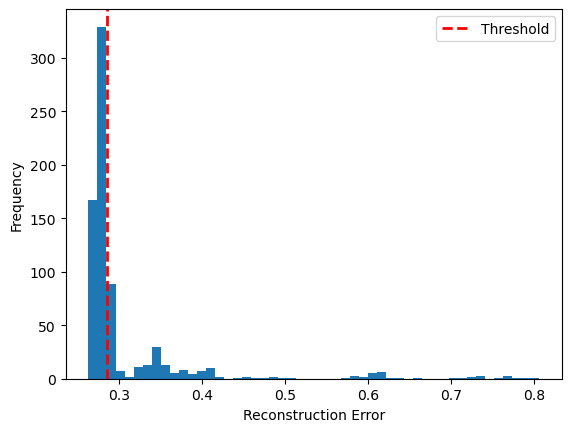

In [56]:
model.eval()  # 모델을 평가 모드로 전환
with torch.no_grad():  # 기울기 계산 비활성화
    reconstructed = model(X_test_tensor)  # 테스트 데이터 복원

# 2. 재구성 오차 계산 (Mean Squared Error)
reconstruction_errors = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1)

# 3. NumPy 배열로 변환
errors = reconstruction_errors.detach().cpu().numpy()

# 4. 임계값 설정 (평균 + 3 * 표준편차 사용)
threshold = np.mean(errors) -0.024 #+ 10 #- 0.001 * np.std(errors)

# 5. 이상치 탐지: 오차가 임계값보다 큰 데이터 찾기
outliers = np.where(errors > threshold)[0]

# 6. 결과 출력
print(f"이상치 인덱스: {outliers}")
print(f"이상치 수: {len(outliers)}")

# 7. 재구성 오차 히스토그램 시각화
import matplotlib.pyplot as plt

plt.hist(errors, bins=50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [47]:
errors

array([0.27889016, 0.26944947, 0.2863557 , 0.27725947, 0.27344394,
       0.34381536, 0.2703378 , 0.34506616, 0.2779378 , 0.27991346,
       0.40837985, 0.27276793, 0.27708542, 0.29199442, 0.2832894 ,
       0.27960405, 0.28358898, 0.30388847, 0.2709495 , 0.277924  ,
       0.27991068, 0.28338113, 0.2829683 , 0.26441386, 0.7535025 ,
       0.28889987, 0.27092078, 0.2848168 , 0.38679978, 0.37483102,
       0.35330433, 0.27932698, 0.28090075, 0.270511  , 0.27068564,
       0.27553833, 0.27735472, 0.28011596, 0.29440594, 0.29622784,
       0.48519176, 0.27483946, 0.3250225 , 0.27353206, 0.2767649 ,
       0.282243  , 0.28560716, 0.27745456, 0.27341706, 0.26788023,
       0.27107903, 0.27656874, 0.27553934, 0.28386664, 0.26731098,
       0.27929813, 0.6138813 , 0.6032356 , 0.27674666, 0.2921795 ,
       0.2817529 , 0.2680391 , 0.28497416, 0.27004007, 0.2805503 ,
       0.7680831 , 0.287219  , 0.27916452, 0.2931224 , 0.2944475 ,
       0.2881938 , 0.27816486, 0.38090706, 0.28391567, 0.34928

In [44]:
test_a['faultNumber'] = test_a['simulationRun'].apply(lambda x: 1 if x in outliers else 0)


In [57]:
test_a['faultNumber'] = test_a['simulationRun'].apply(lambda x: 1 if x in outliers else 0)

prit = test_a[['faultNumber']] 
prit.to_csv("corr_auto.csv", index=True)

In [46]:
prit

,faultNumber
0,0
1,0
2,0
3,0
4,0
...,...
710395,1
710396,1
710397,1
710398,1


가장 빈도가 높은 구간: 0.2744102478027344 ~ 0.28526976704597473
이상치 인덱스: [  2   5   7  10  13  17  24  25  27  28  29  30  38  39  40  42  46  56
  57  59  62  65  66  68  69  70  72  74  75  77  79  81  83  90  93  94
  98 101 103 107 111 114 117 125 126 127 129 131 135 136 139 140 144 145
 146 148 149 154 157 160 162 166 167 169 173 174 175 179 185 187 191 193
 196 201 207 208 217 228 229 233 234 235 239 241 242 243 244 246 248 251
 258 264 265 268 269 274 276 277 278 279 283 289 291 292 294 303 306 312
 315 317 319 320 322 324 332 333 338 347 349 359 360 363 378 380 381 382
 384 385 387 394 398 399 400 402 412 416 418 419 420 422 423 428 432 434
 436 437 438 440 444 448 451 454 455 462 466 468 478 485 487 489 490 492
 495 496 497 500 503 504 507 511 518 526 528 535 537 538 546 549 550 551
 556 560 561 562 563 573 576 591 592 593 594 600 607 608 615 618 620 621
 623 629 632 633 635 640 645 649 651 652 654 665 666 668 673 675 679 683
 686 691 694 698 700 701 702 704 711 714 716 717 718 719 720

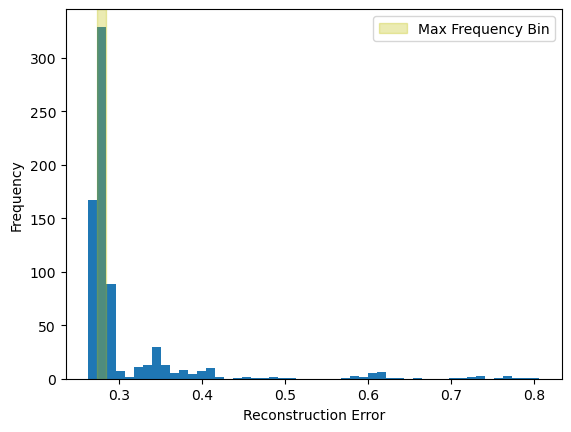

In [58]:
# 1. 히스토그램 그리기 및 데이터 얻기
counts, bins, patches = plt.hist(errors, bins=50)

# 2. 가장 빈도가 높은 막대기의 인덱스 찾기
max_count_index = np.argmax(counts)

# 3. 가장 빈도가 높은 구간 (정상 데이터 구간)
max_bin_start = bins[max_count_index]
max_bin_end = bins[max_count_index + 1]

# 4. 정상 데이터 범위를 제외한 나머지 부분을 이상치로 지정
#outliers = np.where((errors < max_bin_start) | (errors > max_bin_end))[0]
outliers = np.where((errors > max_bin_end))[0]
# 5. 결과 출력
print(f"가장 빈도가 높은 구간: {max_bin_start} ~ {max_bin_end}")
print(f"이상치 인덱스: {outliers}")
print(f"이상치 수: {len(outliers)}")

# 6. 히스토그램 및 가장 빈도가 높은 구간 강조
plt.axvspan(max_bin_start, max_bin_end, color='y', alpha=0.3, label='Max Frequency Bin')  # 가장 높은 막대기 강조
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [59]:
test_a['faultNumber'] = test_a['simulationRun'].apply(lambda x: 1 if x in outliers else 0)

prit = test_a[['faultNumber']] 
prit.to_csv("corr_auto2.csv", index=True)